In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.optimize as optim
import scipy.stats as stats
from scipy.stats import binom
import scipy.special as special

import rare_recurrence as rr
from importlib import reload
reload(rr)

import matplotlib.pyplot as plt

import matplotlib
%matplotlib inline

matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams["figure.facecolor"] = '#ffffff'
sns.set_theme(style="whitegrid", font_scale=2)

In [2]:
def make_bins(jmin, bb, nn, incl_zero=False):
    bins = np.arange(1, jmin + 1, dtype=np.int)
    bb_next = bb
    while bins[-1] > bb_next:
        bb_next *= bb
    bins = np.append(bins, math.floor(bb_next))
    while bins[-1] < nn/2:
        bb_next *= bb
        bins = np.append(bins, math.floor(bb_next))
    bins = np.concatenate((bins[:-1], [math.floor(nn/2), nn]))
    if incl_zero:
        bins = np.concatenate(([0], bins))
    return bins

def expected_vars_standard(bins, theta=1):
    result = np.zeros(len(bins)-1)
    for ii in range(1, len(bins)):
        result[ii-1] = np.sum(1 / np.arange(bins[ii-1], bins[ii]))
    return theta*result

def bin_means(bins):
    result = np.zeros(len(bins)-1)
    for ii in range(1, len(bins)):
        result[ii-1] = np.mean(np.arange(bins[ii-1], bins[ii]))
    return result

def bin_sizes(bins):
    result = np.zeros(len(bins)-1)
    for ii in range(1, len(bins)):
        result[ii-1] = bins[ii] - bins[ii-1]
    return result

def bin_data(ac, nn, bins):
    result = np.zeros(len(bins)-1)
    for ii in range(1, len(bins)):
        sfs_entries = ((ac >= bins[ii-1]) & (ac < bins[ii]))
        result[ii-1] = np.sum(nn[sfs_entries])
    return result

def to_mac(ac, sample_size):
    return np.fmin(ac, sample_size - ac)

def sfs_to_mac(ac, nn, sample_size):
    macs = to_mac(ac, sample_size)
    mac_unique_sort = np.sort(list(set(macs)))
    result_mac = [macs[macs==mac][0] for mac in mac_unique_sort]
    result_nn = [np.sum(nn[macs==mac]) for mac in mac_unique_sort]
    return np.array(result_mac, dtype=np.int), np.array(result_nn)

def local_power_law(ac, nn):
    return (np.log(nn[:-1]) - np.log(nn[1:])) / (np.log(ac[1:]) - np.log(ac[:-1]))

def plot_predict_sfs(ax, bin_points, bin_sizes, obs_sfs, pred_sfs, bin_sizes_pred=None, bin_points_pred=None):
    # scale predicted sfs to observed counts
    pred_sfs_probs = pred_sfs / np.sum(pred_sfs)
    n_obs = np.sum(obs_sfs)
    binom_lower, binom_upper = binom.interval(0.95, int(n_obs), pred_sfs_probs)
    if bin_sizes_pred is None:
        pred_sfs_lower_norm = binom_lower / bin_sizes
        pred_sfs_upper_norm = binom_upper / bin_sizes
        pred_sfs_norm = pred_sfs_probs * n_obs / bin_sizes
    else:
        pred_sfs_lower_norm = binom_lower / bin_sizes_pred
        pred_sfs_upper_norm = binom_upper / bin_sizes_pred
        pred_sfs_norm = pred_sfs_probs * n_obs / bin_sizes_pred
    obs_sfs_norm = obs_sfs / bin_sizes
    
    ax.plot(bin_points, obs_sfs_norm, "o", color="tomato")
    if bin_sizes_pred is None:
        ax.fill_between(bin_points, pred_sfs_lower_norm, pred_sfs_upper_norm, alpha=0.3, color="grey")
        ax.plot(bin_points, pred_sfs_norm, color="black")
    else:
        ax.fill_between(bin_points_pred, pred_sfs_lower_norm, pred_sfs_upper_norm, alpha=0.3, color="grey")
        ax.plot(bin_points_pred, pred_sfs_norm, color="black")
    return ax

def round_to_significant(num, n):
    # Convert the number to a float
    num = np.float64(num)

    # Calculate the exponent of the number
    exponent = np.floor(np.log10(np.abs(num)))

    # Calculate the value of the n-th significant digit
    digit_value = np.round(num / 10 ** (exponent - n + 1))

    # Calculate the rounded value of the number
    rounded_num = digit_value * 10 ** (exponent - n + 1)

    return np.round(rounded_num,12)

To plot the SFS we will look at raw counts from frequency 0 to 40 and then use logarithmic bins above that.

Text(0, 0.5, 'bin count boundaries')

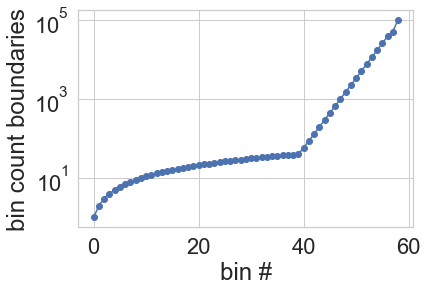

In [3]:
# Just a quick look at bin locations
plt.plot(make_bins(40, 1.5, 100000), "-o")
plt.yscale("log")
plt.xlabel("bin #")
plt.ylabel("bin count boundaries")

/home/evan/miniconda3/envs/smilenfer/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


Text(0, 0.5, '# vars standard coal.')

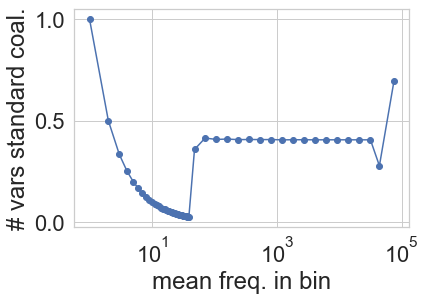

In [4]:
bin_test = make_bins(40, 1.5, 100000, incl_zero=True)
plt.plot(bin_means(bin_test), expected_vars_standard(bin_test), "-o")
plt.xscale("log")
plt.xlabel("mean freq. in bin")
plt.ylabel("# vars standard coal.")

In [5]:
## Read the gnomAD v2 synonymous data in order to get Vova's mutation rate estimates

gnomad_data = pd.read_csv("sfs_mu_bins_allsamp.tsv", sep="\t")
mu_vals = np.sort(np.array(list(set(gnomad_data.mu))))

In [6]:
gnomad_data.head()

,mu,ac,n
0,4.059282e-10,0,44
1,1.319267e-09,0,463705
2,1.319267e-09,1,5700
3,1.319267e-09,2,1122
4,1.319267e-09,3,509


In [7]:
def combine_mu(df, mu_comb):
    result_count = np.sort(np.array(list(set(np.concatenate([gnomad_data["ac"].to_numpy()[np.where(gnomad_data.mu==mu)] 
                                                             for mu in mu_comb])))))
    result_n = np.zeros_like(result_count, dtype=np.float64)
    for mu in mu_comb:
        test_inds = np.where((gnomad_data.mu==mu))
        test_count = gnomad_data["ac"].to_numpy()[test_inds]
        test_n = gnomad_data["n"].to_numpy()[test_inds]
        for ii, count in enumerate(test_count):
            result_n[result_count == count] += test_n[ii]
    return result_count, result_n

count_low_mu, n_low_mu = combine_mu(gnomad_data, mu_vals[0:10])
count_lower_half, n_lower_half = combine_mu(gnomad_data, mu_vals[0:49])
count_upper_half, n_upper_half = combine_mu(gnomad_data, mu_vals[65:])
count_all, n_all = combine_mu(gnomad_data, mu_vals)

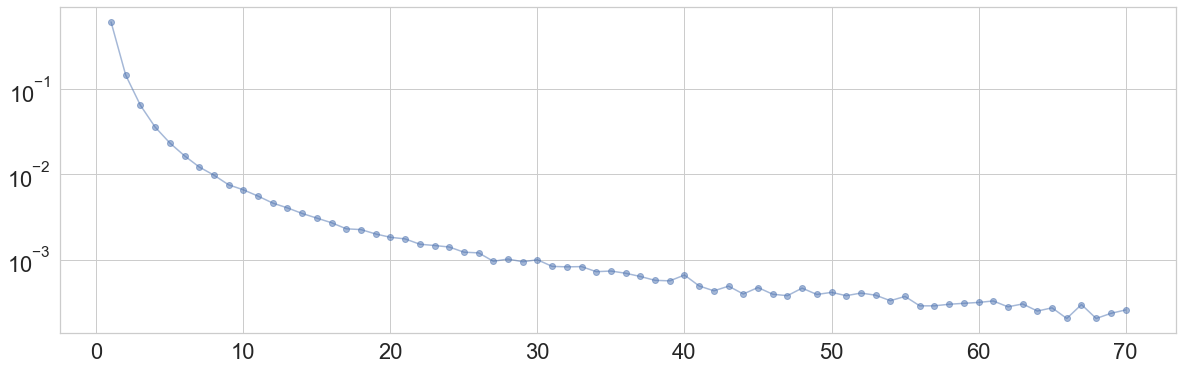

In [8]:
Ti_empirical = n_low_mu[1:71]
Ti_empirical = Ti_empirical/np.sum(Ti_empirical)

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(range(1, 71), Ti_empirical, "-o", alpha=0.5)
plt.yscale("log")

In [9]:
Ti_fit = Ti_empirical[0:40]
part_mats_fit = rr.partition_matrices(40, 7)

Read in SFS count data separated into mutation rate bins. Fitted probabilities from demographic simulations are given in the `sim` column. `mu_pergen` represents Roulette estimates.

In [10]:
SFS_obs_sim = pd.read_csv("SFS_observed_and_simulated.tsv.gz", sep="\t", compression="gzip")

In [11]:
SFS_obs_sim.head(n=100)

,AC,sim,Count,Prop,mu,mu_pergen,mu_fit
0,0,0.877174,113258.0,0.873931,0.198,2.009345e-08,1.900000e-08
1,1,0.067517,9698.0,0.074833,0.198,2.009345e-08,1.900000e-08
2,2,0.019774,2400.0,0.018519,0.198,2.009345e-08,1.900000e-08
3,3,0.008902,1045.0,0.008064,0.198,2.009345e-08,1.900000e-08
4,4,0.005008,613.0,0.004730,0.198,2.009345e-08,1.900000e-08
...,...,...,...,...,...,...,...
95,95,0.000013,1.0,0.000008,0.198,2.009345e-08,1.900000e-08
96,96,0.000013,1.0,0.000008,0.198,2.009345e-08,1.900000e-08
97,97,0.000012,0.0,0.000000,0.198,2.009345e-08,1.900000e-08
98,98,0.000012,2.0,0.000015,0.198,2.009345e-08,1.900000e-08


In [12]:
# Mutation rate values for each bin
mu_vals_sims = np.sort(np.array(list(set(SFS_obs_sim.mu_pergen))))
mu_vals_low = mu_vals_sims


In [13]:
# Subset the data frame to the SFS for a particular mutation rate bin
def get_obs_sim(ii):
    inds = SFS_obs_sim.mu_pergen==mu_vals_sims[ii]
    return SFS_obs_sim.AC.to_numpy()[inds], SFS_obs_sim.Count.to_numpy()[inds], SFS_obs_sim.sim.to_numpy()[inds]

In [14]:
SFS_obs_sim_high = pd.read_csv("SFS_observed_and_simulated_highmut.tsv.gz", sep="\t", compression="gzip")
SFS_obs_sim_low = pd.read_csv("SFS_observed_and_simulated_lowmut_new.tsv.gz", sep="\t", compression="gzip")

In [15]:
SFS_obs_sim_high.head()

,AC,sim,Count,Prop,mu_fit
0,0,0.271991,95401.0,0.283035,1.900000e-07
1,1,0.208357,69900.0,0.207379,1.900000e-07
2,2,0.132750,44853.0,0.133070,1.900000e-07
3,3,0.084020,28701.0,0.085150,1.900000e-07
4,4,0.055168,18844.0,0.055906,1.900000e-07


In [16]:
sample_size = 114000

Make bins, single frequency up to 40, then log base 3 after that.

In [17]:
bin_test_mac = make_bins(40, 3, sample_size/2, incl_zero=True)
bin_test_mac_nz = make_bins(40, 1.5, sample_size/2, incl_zero=False)
bin_test_sizes_mac = bin_sizes(bin_test_mac)
bin_test_sizes_mac_nz = bin_sizes(bin_test_mac_nz)

In [18]:
AC_sim_ex, n_sim_ex, p_sim_ex = get_obs_sim(1)
bin_sim_test = bin_data(AC_sim_ex, p_sim_ex, bin_test_mac)
bin_sim_test

array([9.86306687e-01, 7.98170693e-03, 2.07349004e-03, 9.10650610e-04,
       5.08297868e-04, 3.23928209e-04, 2.24578392e-04, 1.64953514e-04,
       1.26262838e-04, 9.96880433e-05, 8.07001241e-05, 6.67657786e-05,
       5.63402534e-05, 4.84089965e-05, 4.22715473e-05, 3.74316865e-05,
       3.35347598e-05, 3.03274653e-05, 2.76297497e-05, 2.53142370e-05,
       2.32910144e-05, 2.14965706e-05, 1.98859672e-05, 1.84273669e-05,
       1.70981189e-05, 1.58818103e-05, 1.47659712e-05, 1.37403493e-05,
       1.27957765e-05, 1.19236264e-05, 1.11157733e-05, 1.03648753e-05,
       9.66476566e-06, 9.01076528e-06, 8.39979613e-06, 7.83026257e-06,
       7.30173607e-06, 6.81452062e-06, 6.36918641e-06, 5.96614666e-06,
       1.33939629e-04, 1.10559108e-04, 6.89571125e-05, 5.57370769e-05,
       5.19908470e-05, 6.14393122e-05, 3.22676156e-05, 6.39963841e-05])

Take a quick look at the low rate sfs


Text(0, 0.5, 'count')

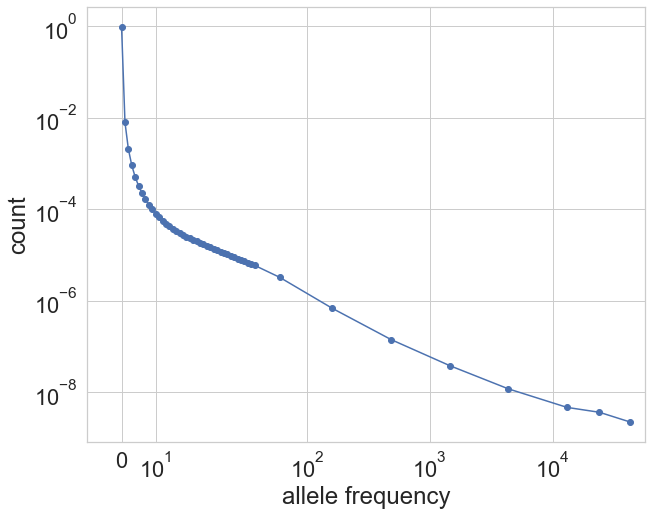

In [19]:
_, _ = plt.subplots(figsize=(10,8))
plt.plot(bin_means(bin_test_mac), bin_sim_test/bin_test_sizes_mac, "-o")
plt.yscale("log")
plt.xscale("symlog", linthresh=40)
plt.xlim([-10, sample_size/2])
plt.xlabel("allele frequency")
plt.ylabel("count")

Bin the sfs for the low and high mutation rate bins.

In [20]:
n_sim_bin_low =  bin_data(SFS_obs_sim_low.AC.to_numpy(), SFS_obs_sim_low.Count.to_numpy(), bin_test_mac)
p_sim_bin_low =  bin_data(SFS_obs_sim_low.AC.to_numpy(), SFS_obs_sim_low.sim.to_numpy(), bin_test_mac)

n_sim_bin_high = bin_data(SFS_obs_sim_high.AC.to_numpy(), SFS_obs_sim_high.Count.to_numpy(), bin_test_mac)
p_sim_bin_high = bin_data(SFS_obs_sim_high.AC.to_numpy(), SFS_obs_sim_high.sim.to_numpy(), bin_test_mac)

In [21]:
AC_sim_ex, n_sim_ex, p_sim_ex = get_obs_sim(2)
p_sim_bin = bin_data(AC_sim_ex, p_sim_ex, bin_test_mac)
n_sim_bin = bin_data(AC_sim_ex, n_sim_ex, bin_test_mac)

For each mutation rate bin from Roulette, calculate and compare the log likelihood for the bin specific scaling to the scaling for both the low-rate binning and high-rate binning.

In [22]:
n_obs_low_set = []
scaled_diffs_low = []
low_samp_residuals = []
ll_low_bins = []
ll_low_all = []

for ii, mu in enumerate(mu_vals_sims):
    mu = mu_vals_sims[ii]
    AC_sim_ex, n_sim_ex, p_sim_ex = get_obs_sim(np.where(mu == mu_vals_sims)[0][0])
    p_sim_bin = bin_data(AC_sim_ex, p_sim_ex, bin_test_mac)
    n_sim_bin = bin_data(AC_sim_ex, n_sim_ex, bin_test_mac)
    
    p_sim_bin_poly = p_sim_bin[1:]/np.sum(p_sim_bin[1:])
    ll_sim_bin = np.sum(np.log(p_sim_bin_poly) * n_sim_bin[1:])
    ll_low_bins.append(ll_sim_bin)
    
    p_sim_bin_low_poly = p_sim_bin_low[1:]/np.sum(p_sim_bin_low[1:])
    
    ll_sim_low = np.sum(np.log(p_sim_bin_low_poly) * n_sim_bin[1:])
    ll_low_all.append(ll_sim_low)
    n_obs = np.sum(n_sim_bin[1:])
    n_obs_low_set.append(n_obs)

In [23]:
n_obs_high_set = []
scaled_diffs_high = []
high_samp_residuals = []
ll_high_bins = []
ll_high_all = []

mu_vals_high = mu_vals_sims
for ii, mu in enumerate(mu_vals_sims):
    mu = mu_vals_sims[ii]
    AC_sim_ex, n_sim_ex, p_sim_ex = get_obs_sim(np.where(mu == mu_vals_sims)[0][0])
    p_sim_bin = bin_data(AC_sim_ex, p_sim_ex, bin_test_mac)
    n_sim_bin = bin_data(AC_sim_ex, n_sim_ex, bin_test_mac)
    
    p_sim_bin_poly = p_sim_bin[1:]/np.sum(p_sim_bin[1:])
    ll_sim_bin = np.sum(np.log(p_sim_bin_poly) * n_sim_bin[1:])
    ll_high_bins.append(ll_sim_bin)
    
    p_sim_bin_high_poly = p_sim_bin_high[1:]/np.sum(p_sim_bin_high[1:])
    
    ll_sim_high = np.sum(np.log(p_sim_bin_high_poly) * n_sim_bin[1:])
    ll_high_all.append(ll_sim_high)
    n_obs = np.sum(n_sim_bin[1:])
    n_obs_high_set.append(n_obs)

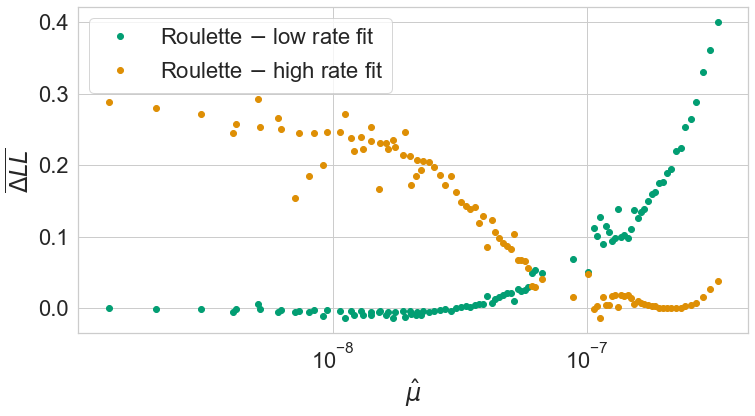

In [24]:
_, _ = plt.subplots(figsize=(12,6))
plt.plot(mu_vals_sims, (np.array(ll_low_bins)- 1)/np.array(n_obs_low_set) - np.array(ll_low_all)/np.array(n_obs_low_set), "o",
         label=r"Roulette $-$ low rate fit", color=sns.color_palette("colorblind")[2])
plt.plot(mu_vals_sims, (np.array(ll_high_bins) - 1)/np.array(n_obs_high_set) - np.array(ll_high_all)/np.array(n_obs_high_set), "o",
        label=r"Roulette $-$ high rate fit", color=sns.color_palette("colorblind")[1]) 
plt.xscale("log")
plt.xlabel(r"$\hat{\mu}$")
plt.ylabel(r"$\overline{\Delta LL}$")
plt.legend()

Take a quick look at fits to low and high rate grouped bins.

Text(0.5, 1.0, 'high bins')

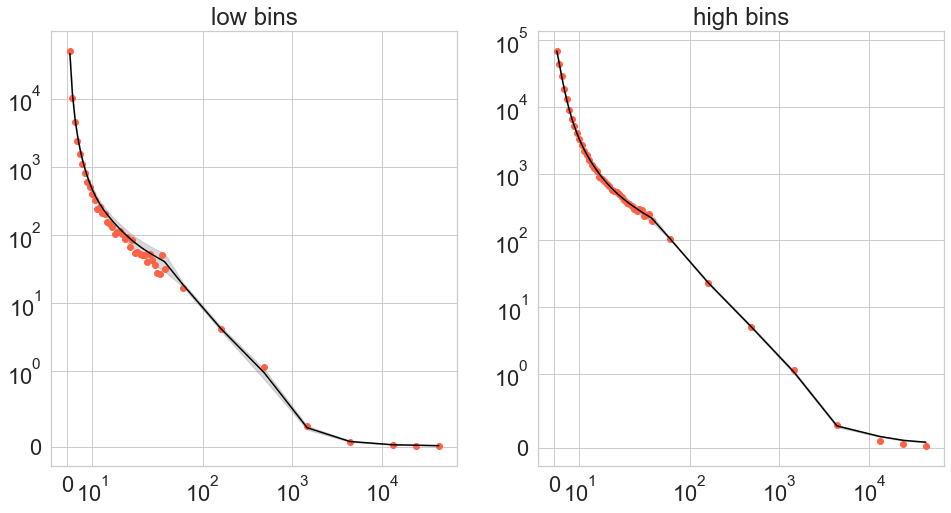

In [25]:
n_sim_bin_low = bin_data(SFS_obs_sim_low.AC.to_numpy(), SFS_obs_sim_low.Count.to_numpy(), bin_test_mac)
p_sim_bin_low = bin_data(SFS_obs_sim_low.AC.to_numpy(), SFS_obs_sim_low.sim.to_numpy(), bin_test_mac)
n_sim_bin_high = bin_data(SFS_obs_sim_high.AC.to_numpy(), SFS_obs_sim_high.Count.to_numpy(), bin_test_mac)
p_sim_bin_high = bin_data(SFS_obs_sim_high.AC.to_numpy(), SFS_obs_sim_high.sim.to_numpy(), bin_test_mac)

ii = 4
mu = mu_vals_sims[ii]
AC_sim_ex, n_sim_ex, p_sim_ex = get_obs_sim(ii)
n_sim_bin = bin_data(AC_sim_ex, n_sim_ex, bin_test_mac)
p_sim_bin = bin_data(AC_sim_ex, p_sim_ex, bin_test_mac)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0] = plot_predict_sfs(axes[0], bin_means(bin_test_mac)[1:], bin_test_sizes_mac[1:], 
                                              n_sim_bin_low[1:], p_sim_bin_low[1:])

axes[0].set_yscale("symlog", linthresh=1)
axes[0].set_xscale("symlog", linthresh=40)
axes[0].set_title("low bins")

axes[1] = plot_predict_sfs(axes[1], bin_means(bin_test_mac)[1:], bin_test_sizes_mac[1:], 
                                n_sim_bin_high[1:], p_sim_bin_high[1:])

axes[1].set_yscale("symlog", linthresh=1)
axes[1].set_xscale("symlog", linthresh=40)
axes[1].set_title("high bins")

Make some test recurrent SFS for different mutation rate magnitudes under exponential growth.

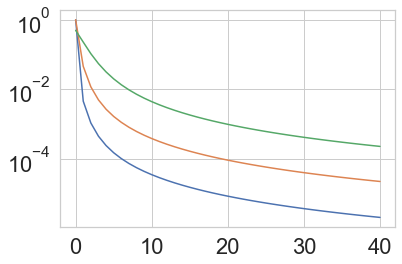

In [26]:
sfs_low_exp = rr.recur_sfs_exp(part_mats_fit, 40, 7, 0.02, 6.0)
sfs_med_exp = rr.recur_sfs_exp(part_mats_fit, 40, 7, 0.2, 6.0)
sfs_high_exp = rr.recur_sfs_exp(part_mats_fit, 40, 7, 2.0, 6.0)

plt.plot(sfs_low_exp/np.sum(sfs_low_exp))
plt.plot(sfs_med_exp/np.sum(sfs_low_exp))
plt.plot(sfs_high_exp/np.sum(sfs_high_exp))
plt.yscale("log")

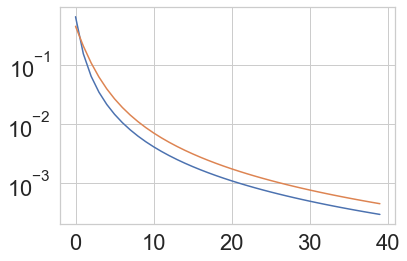

In [27]:
sfs_low_exp_probs = sfs_low_exp[1:]/np.sum(sfs_low_exp[1:])
sfs_med_exp_probs = sfs_med_exp[1:]/np.sum(sfs_med_exp[1:])
sfs_high_exp_probs = sfs_high_exp[1:]/np.sum(sfs_high_exp[1:])

plt.plot(sfs_low_exp_probs)
plt.plot(sfs_high_exp_probs)
plt.yscale("log")

In [28]:
low_samp = stats.multinomial.rvs(100000, sfs_low_exp_probs)
med_samp = stats.multinomial.rvs(100000, sfs_med_exp_probs)
high_samp = stats.multinomial.rvs(100000, sfs_high_exp_probs)

Compute likelihood surfaces.

In [29]:
Upsilon_set = np.linspace(4, 10, 100)
Upsilon_llhood_low =  [rr.sfs_llhood_exp(np.arange(0, 40), low_samp, 0.02, Upsilon, 40, 7, part_mats_fit, nz=True) 
                       for Upsilon in Upsilon_set]

In [30]:
Upsilon_llhood_med = [ rr.sfs_llhood_exp(np.arange(0, 40), med_samp, 0.2, Upsilon, 40, 7, part_mats_fit, nz=True)
                       for Upsilon in Upsilon_set]

Upsilon_llhood_high = [ rr.sfs_llhood_exp(np.arange(0, 40), high_samp, 2.0, Upsilon, 40, 7, part_mats_fit, nz=True)
                       for Upsilon in Upsilon_set]

In [31]:
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
sns.set(style="whitegrid", rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style('whitegrid')

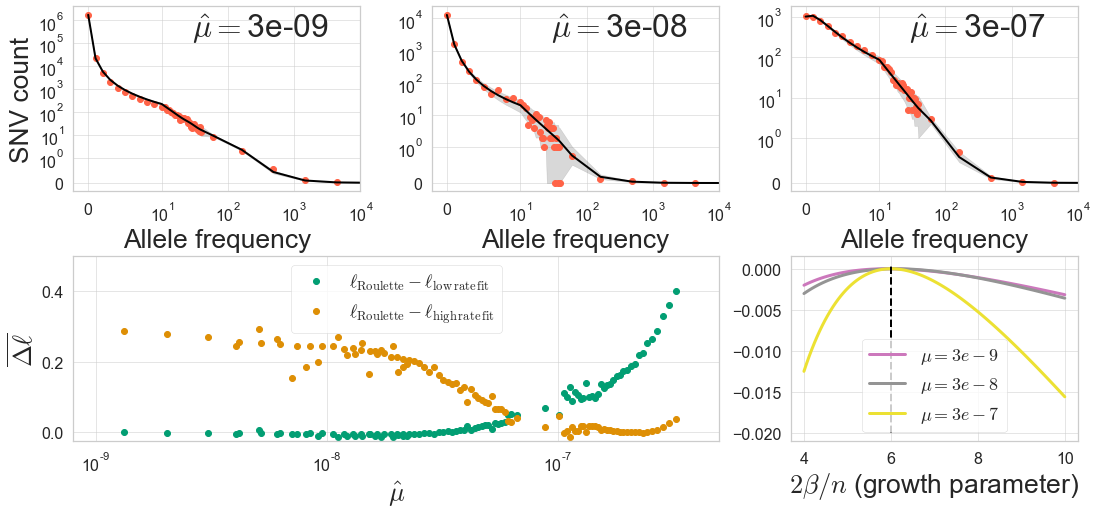

In [32]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams["figure.facecolor"] = '#ffffff'
matplotlib.rcParams["axes.facecolor"] = "#ffffff"
matplotlib.rcParams["savefig.facecolor"] = "#ffffff"
plt.style.use('bmh')
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
sns.set_style('whitegrid')

ii_set = [2,42,-2]
fig, axes = plt.subplots(2, len(ii_set), figsize=(18,8))

for jj,ii in enumerate(ii_set):
    mu = mu_vals_sims[ii]
    AC_sim_ex, n_sim_ex, p_sim_ex = get_obs_sim(ii)
    bin_sim_test = bin_data(AC_sim_ex, p_sim_ex, bin_test_mac)
    bin_n_test = bin_data(AC_sim_ex, n_sim_ex, bin_test_mac)
    n_obs = np.sum(bin_n_test)
    axes[0][jj] = plot_predict_sfs(axes[0][jj], bin_means(bin_test_mac), bin_test_sizes_mac, 
                                bin_n_test, bin_sim_test)
    axes[0][jj].set_title(r"$\hat{\mu}=$" + "{}".format(round_to_significant(mu_vals_sims[ii], 1)), x=0.65, y=0.80)
    axes[0][jj].set_yscale("symlog", linthresh=1)
    axes[0][jj].set_xscale("symlog", linthresh=10)
    axes[0][jj].set_xlim([-2,10000])

gs = axes[1, 1].get_gridspec()
for ax in axes[1,0:-1]:
    ax.remove()
axbig = fig.add_subplot(gs[1,0:-1])
axbig.plot(mu_vals_sims, ((np.array(ll_low_bins)-1)/np.array(n_obs_low_set) - np.array(ll_low_all)/np.array(n_obs_low_set)), "o",
         label=r"$\ell_{\mathrm{Roulette}}-\ell_{\mathrm{low \, rate \, fit}}$", color=sns.color_palette("colorblind")[2])
axbig.plot(mu_vals_high, ((np.array(ll_high_bins)-1)/np.array(n_obs_high_set) - np.array(ll_high_all)/np.array(n_obs_high_set)), "o",
        label=r"$\ell_{\mathrm{Roulette}}-\ell_{\mathrm{high \, rate \, fit}}$", color=sns.color_palette("colorblind")[1]) 
axbig.set_xscale("log")
#axbig.set_yscale("symlog", linthresh=0.05)

axbig.set_xlabel(r"$\hat{\mu}$")
axbig.set_ylabel(r"$\overline{\Delta \ell}$")
axbig.legend(loc="upper center", fontsize=18)
axbig.set_xlim([0.8e-9, 5e-7])
axbig.set_ylim([-0.025, 0.5])
axbig.minorticks_on()

axes[1][2].plot(Upsilon_set, (Upsilon_llhood_low - np.max(Upsilon_llhood_low))/100000, 
                label=r"$\mu=3e-9$", linewidth=3, color=sns.color_palette("colorblind")[4])
axes[1][2].plot(Upsilon_set, (Upsilon_llhood_med - np.max(Upsilon_llhood_med))/100000, 
                label=r"$\mu=3e-8$", linewidth=3, color=sns.color_palette("colorblind")[7])
axes[1][2].plot(Upsilon_set, (Upsilon_llhood_high - np.max(Upsilon_llhood_high))/100000, 
                label=r"$\mu=3e-7$", linewidth=3, color=sns.color_palette("colorblind")[8])
axes[1][2].plot([6, 6], [-200/10000, 5/10000], "--", color="black")
axes[1][2].set_xlabel(r"$2\beta/n$ (growth parameter)")
axes[1][2].legend(loc="lower center", fontsize=18)

axes[0][0].set_ylabel("SNV count")
axes[0][0].set_xlabel("Allele frequency")
axes[0][1].set_xlabel("Allele frequency")
axes[0][2].set_xlabel("Allele frequency")

plt.subplots_adjust(hspace=0.35)
plt.subplots_adjust(wspace=0.25)
fig.savefig("demography_plot_full.svg", bbox_inches="tight")